In [1]:
# Library Import & Settings
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pykrige.ok import OrdinaryKriging

In [2]:
# Visualization Settings
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

def format_ax(ax, title, xlabel, ylabel, title_fontsize=18, label_fontsize=14):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)

In [3]:
# 2. Load Data & One-Hot Encoding (LITHOIDX)
# ---------------------------------------------------------
data_path = 'AlNiFe_data2.csv'
df = pd.read_csv(data_path)

# One-Hot Encoding
if 'LITHOIDX' in df.columns:
    df['LITHOIDX'] = df['LITHOIDX'].astype(str) # 숫자를 문자로 변환
    df = pd.get_dummies(df, columns=['LITHOIDX'], prefix='Litho', drop_first=False)
    bool_cols = [col for col in df.columns if 'Litho_' in col]
    df[bool_cols] = df[bool_cols].astype(int)

print("One-Hot Encoding Completed. Columns:", df.columns)

# Define Variables
predictor_cols = [col for col in df.columns if col not in ['AL', 'FE', 'NI', 'X_utm', 'Y_utm']] 

lon = df['X_utm'].values
lat = df['Y_utm'].values
al = df['AL'].values
coor = np.column_stack((lon, lat))

One-Hot Encoding Completed. Columns: Index(['AL', 'FE', 'NI', 'X_utm', 'Y_utm', 'GRV_IDW', 'MAG_IDW', 'FaultDist',
       'FaultDensity', 'DepositDist', 'Litho_CEj', 'Litho_CEm', 'Litho_CEp',
       'Litho_CEs', 'Litho_CEw', 'Litho_Kav', 'Litho_Kh', 'Litho_Kj',
       'Litho_Od', 'Litho_Odu', 'Litho_Omg', 'Litho_PCEchgr', 'Litho_PCEggn',
       'Litho_PCEgnb', 'Litho_PCEgrgn', 'Litho_PCEhgr', 'Litho_PCEmgn',
       'Litho_PCEy', 'Litho_PCEygo', 'Litho_Ps', 'Litho_Qd', 'Litho_Qr',
       'Litho_TRg', 'Litho_TRn', 'Litho_TRn1', 'Litho_TRn2', 'Litho_TRn3',
       'Litho_c', 'Litho_chs', 'Litho_m'],
      dtype='object')


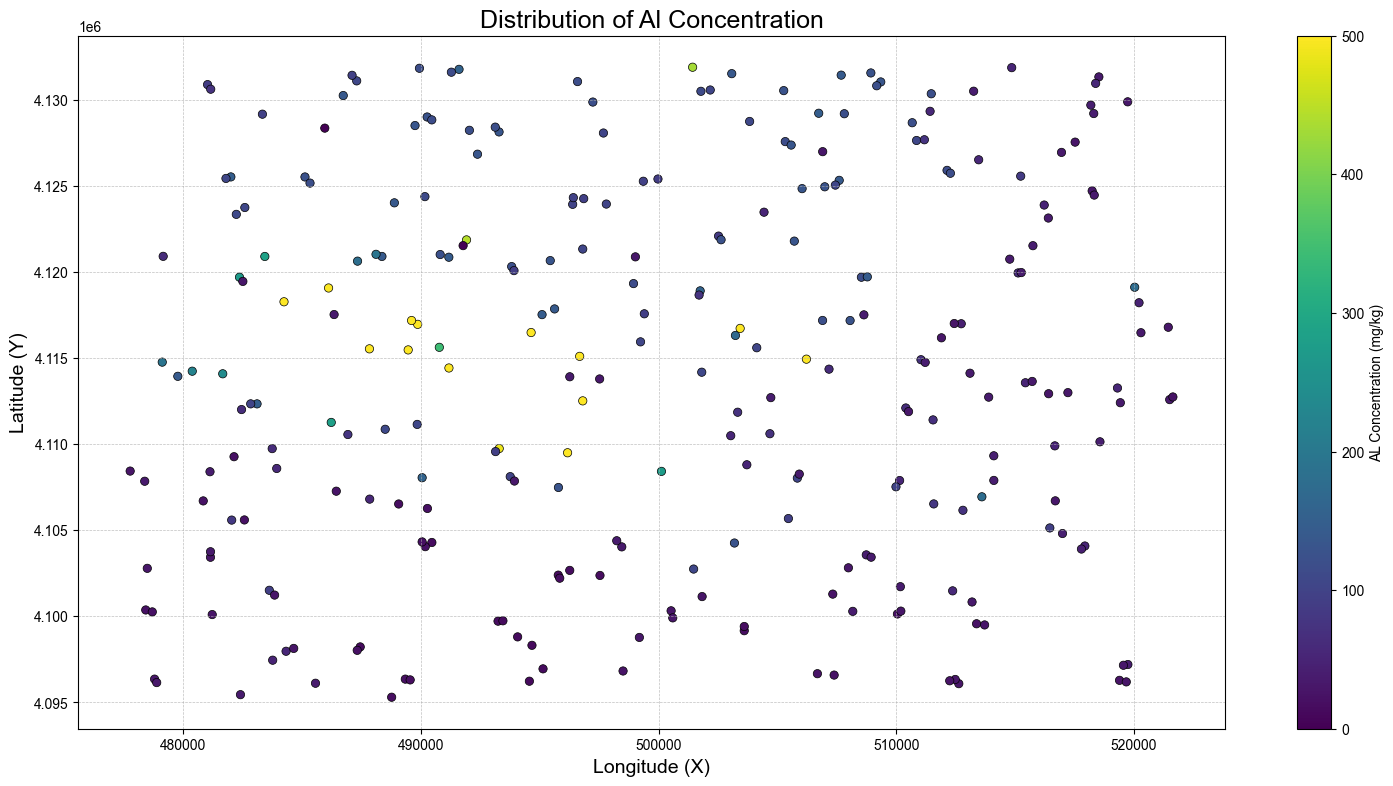

In [23]:
# Visualization of entire data distribution
fig, ax = plt.subplots(figsize=(18.5, 9))
sc = ax.scatter(coor[:, 0], coor[:, 1], c=al, cmap='viridis', edgecolor='k', linewidths=0.5)
ax.set_title('Distribution of Al Concentration', fontsize=18)
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
ax.tick_params(axis='x', rotation=0)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)
fig.colorbar(sc, ax=ax, label='AL Concentration (mg/kg)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

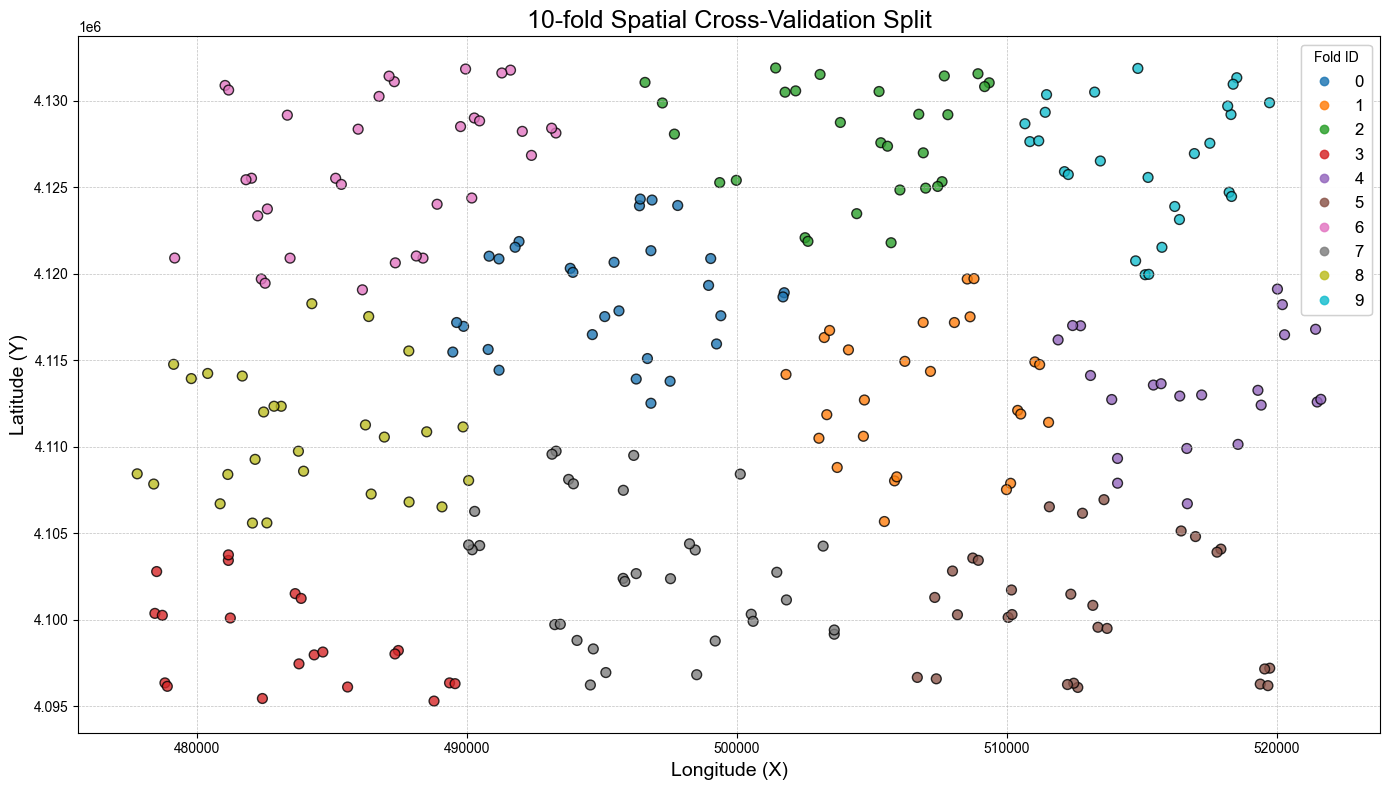

In [17]:
# Spatial K-Fold (k=10)

k_folds = 10
kmeans = KMeans(n_clusters=k_folds, random_state=42, n_init=10)
df['Spatial_Fold'] = kmeans.fit_predict(coor)

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
scatter = ax.scatter(lon, lat, c=df['Spatial_Fold'], cmap='tab10', s=50, edgecolor='k', alpha=0.8)

ax.set_title(f'{k_folds}-fold Spatial Cross-Validation Split', fontsize=18)
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
ax.tick_params(axis='x', rotation=0)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)

# Legend (Fold Number)
handles, labels = scatter.legend_elements()
legend = ax.legend(handles, labels, title="Fold ID", loc="upper right", fontsize=12)
ax.add_artist(legend)

plt.tight_layout()
plt.show()

In [25]:
# Descriptive statistics for Al and other numeric variables
def describe_series(values: pd.Series) -> dict:
    """단일 변수에 대한 기술통계."""
    s = values.dropna()
    return {
        "Mean": s.mean(),
        "Median": s.median(),
        "Std": s.std(ddof=1),
        "Min": s.min(),
        "Q1": s.quantile(0.25),
        "Q3": s.quantile(0.75),
        "Max": s.max(),
        "Skewness": stats.skew(s, bias=False),
        "Kurtosis": stats.kurtosis(s, bias=False),
    }

stats_list = []

for col in numeric_cols:
    vals = df[col]
    desc = describe_series(vals)
    if col != 'AL':
        valid = df[['AL', col]].dropna()
        rho, _ = stats.spearmanr(valid[col], valid['AL'])
        desc['Spearman_rho_with_AL'] = rho
    else:
        desc['Spearman_rho_with_AL'] = np.nan  

    desc['Variable'] = col
    stats_list.append(desc)

stats_df = pd.DataFrame(stats_list).set_index('Variable')

print("\n=== Descriptive Statistics for Table 4 ===")
print(stats_df.round(2))


=== Descriptive Statistics for Table 4 ===
                 Mean   Median      Std     Min       Q1       Q3       Max  \
Variable                                                                      
AL             100.76    62.50   112.23    0.00    33.00   121.25    500.00   
GRV_IDW         -0.58    -1.58     9.54  -16.62    -8.27     7.46     18.98   
MAG_IDW        -65.98   -69.59    45.20 -192.22   -94.19   -46.00    114.28   
FaultDist     1565.66   894.43  1700.34    0.00   409.23  2042.66   8228.00   
FaultDensity   620.22   182.25   919.43    0.00     0.00  1003.90   6106.23   
DepositDist   7608.10  7024.48  4265.09  300.00  4669.57  9719.69  21253.23   

              Skewness  Kurtosis  Spearman_rho_with_AL  
Variable                                                
AL                2.53      6.23                   NaN  
GRV_IDW           0.26     -1.00                 -0.13  
MAG_IDW           0.43      1.44                 -0.11  
FaultDist         1.69      2.45      


Calculating Experimental Semivariogram for Raw Data...


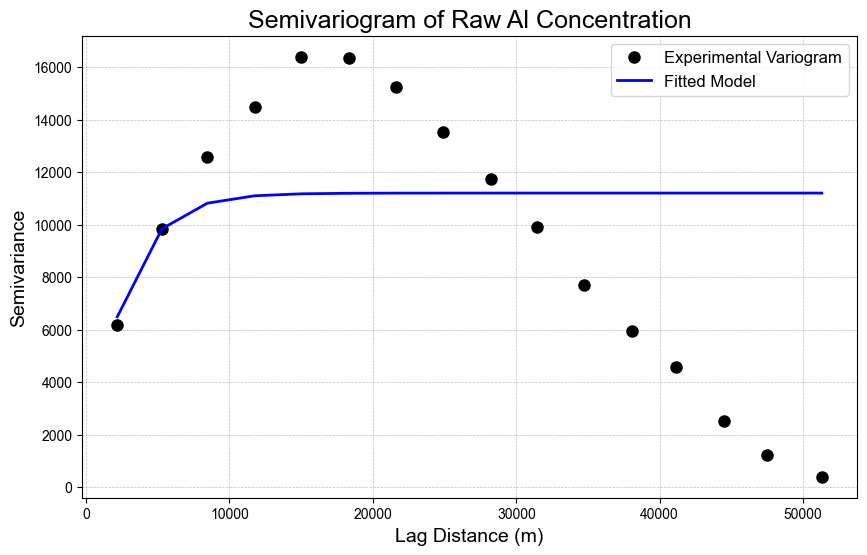

Variogram Parameters: [1.12013870e+04 7.52843157e+03 1.38608505e-02]


In [29]:
# Geostatistical Analysis: Variogram of Raw Data
print("\nCalculating Experimental Semivariogram for Raw Data...")

# OK 모델을 초기화하면서 variogram을 계산
ok_model = OrdinaryKriging(
    lon, lat, al,
    variogram_model='exponential', # 'exponential', 'gaussian'
    verbose=False,
    enable_plotting=False,
    nlags=16  # Lag (데이터 밀도에 따라 조정, 10~20 추천)
)

# 배리오그램 데이터 추출
lags = ok_model.lags
semivariance = ok_model.semivariance
variogram_model_values = ok_model.variogram_function(ok_model.variogram_model_parameters, lags)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lags, semivariance, 'ko', markersize=8, label='Experimental Variogram') # 실험치 (점)
ax.plot(lags, variogram_model_values, 'b-', linewidth=2, label='Fitted Model')  # 이론치 (선)

format_ax(ax, 'Semivariogram of Raw Al Concentration', 'Lag Distance (m)', 'Semivariance')
ax.legend(fontsize=12)
plt.show()

print("Variogram Parameters:", ok_model.variogram_model_parameters)

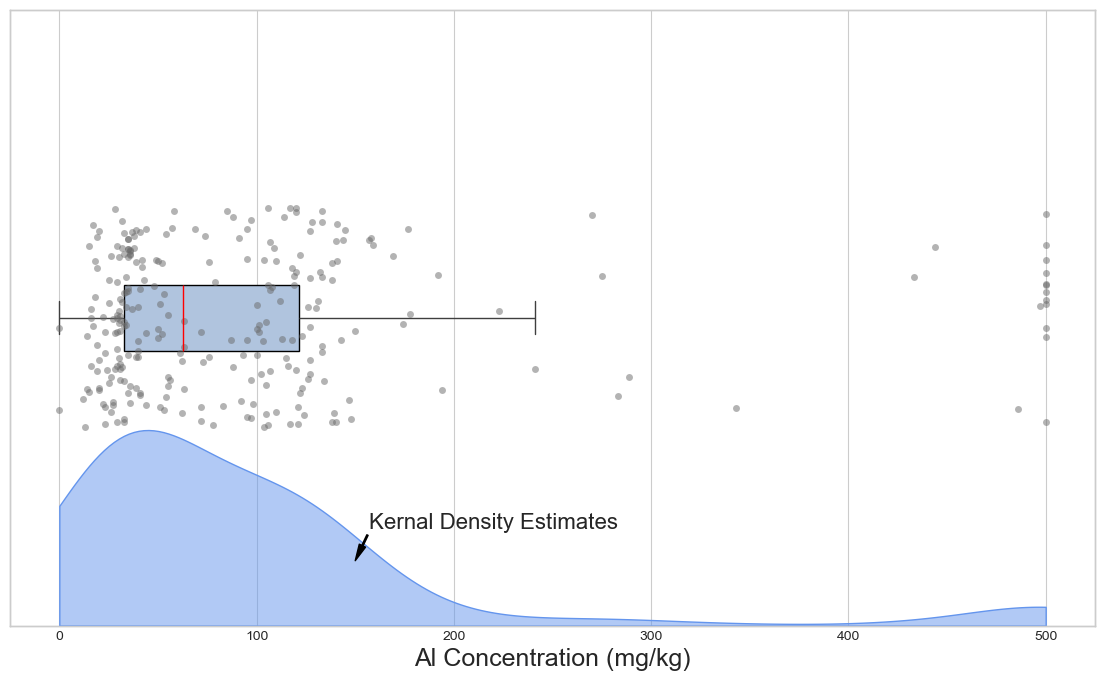

In [31]:
plt.style.use('seaborn-v0_8-whitegrid')

# 그림 사이즈 설정
fig, ax = plt.subplots(figsize=(14, 8))

# 1. KDE Plot (구름) - 상단에 위치
#    y축을 공유하지 않기 위해 별도의 ax를 생성하여 그립니다.
ax_kde = ax.twinx()
sns.kdeplot(x=al, fill=True, alpha=0.5, color='cornflowerblue', ax=ax_kde, cut=0)
ax_kde.set_yticks([]) # KDE 축의 y눈금은 불필요
ax_kde.set_ylabel('')
ax_kde.annotate('Kernal Density Estimates', 
              xy=(150, 0.002),  # 화살표가 가리킬 지점
              xytext=(220, 0.003), # 텍스트가 위치할 지점
              arrowprops=dict(facecolor='black', shrink=0.0005, width=1, headwidth=5),
              fontsize=16,
              ha='center')

# 2. 데이터 포인트 (빗방울)와 박스플롯 (상자) - 하단에 위치
#    ptitprince 라이브러리의 RainCloud와 유사하게 수동으로 구현
sns.stripplot(x=al, ax=ax, jitter=0.25, size=5, color='dimgray', alpha=0.5)
sns.boxplot(x=al, ax=ax, width=0.15, showfliers=False, # 이상치는 stripplot이 보여주므로 생략
            boxprops={'facecolor':'lightsteelblue', 'edgecolor':'black', 'zorder': 2},
            medianprops={'color':'red', 'zorder': 3})

# 축 및 타이틀 설정
ax.set_xlabel('Al Concentration (mg/kg)', fontsize=18)
ax.set_yticks([]) # y축은 위치 구분을 위한 것이므로 눈금 제거
ax.set_ylabel('')

# KDE 플롯이 박스플롯 위로 올라오도록 zorder 설정 및 y축 범위 조정
ax_kde.set_ylim(0, ax_kde.get_ylim()[1] * 3) # KDE 높이가 잘 보이도록 조정
ax.set_ylim(-0.7, 0.7) # 박스플롯과 점들이 잘 보이도록 조정

plt.show()